In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [27]:
a = pd.read_csv('./toy.csv')
d = a.values
a.describe()
# print d.shape


,var1,var2,label
count,100.000000,100.000000,100.000000
mean,0.788559,4.413645,0.500000
std,5.614973,2.288227,0.502519
min,-8.719130,2.026715,0.000000
25%,-3.944210,2.573399,0.000000
50%,1.428670,2.972816,0.500000
75%,5.917302,6.148908,1.000000
max,9.884114,10.877416,1.000000


In [28]:
x_val = np.linspace(-10, 10)
print d[:5]

[[  6.02494983  10.87741633   1.        ]
 [ -1.41197734   6.01971808   1.        ]
 [  6.49701735   7.50608586   1.        ]
 [  1.92901092   2.5803534    0.        ]
 [ -5.26320254   8.5527217    1.        ]]


In [15]:
def sigmoid(x):
    return 1/(1.0 + np.exp(-1.0 * x))

def tanh(x):
    return np.tanh(x)

def scaled_tanh(x):
    return (tanh(x) + 1)/2.0

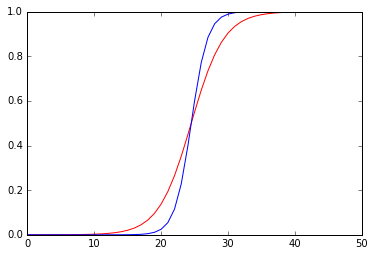

In [20]:
a = sigmoid(x_val)
b = scaled_tanh(x_val)

plt.figure(0)
plt.plot(a, 'r')
plt.plot(b)
plt.show()

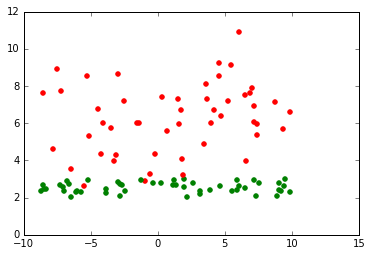

In [21]:
for ix in range(100):
    if d[ix, 2] == 1:
        plt.scatter(d[ix, 0], d[ix, 1], color='red')
    else:
        plt.scatter(d[ix, 0], d[ix, 1], color='green')

In [26]:
X = d[:, :2]
y = d[:, 2]
print X.shape, y.shape

(100, 2) (100,)


In [112]:
class LogisticRegression:

    def __init__(self,X,y, alpha=1e-2, max_epochs=1e3, tolerance=1e-5, decay_factor=10.0, use_adaptive=False):
        self.tolerance = tolerance
        self.labels = y.reshape(y.size,1)
        self.w = np.zeros((X.shape[1]+1,1))
        self.X = X
        self.mean_x = X.mean(axis=0)
        self.std_x = X.std(axis=0)
        self.features = np.ones((X.shape[0],X.shape[1]+1))
        self.features[:,1:] = (X-self.mean_x)/self.std_x
        self.shuffled_features = self.features
        self.shuffled_labels = self.labels
        self.likelihood_history = []
        self.training_alpha = alpha
        self.max_epochs = max_epochs
        self.decay_factor = decay_factor
        self.use_adaptive = use_adaptive


    def log_likelihood(self):
        p = self.probability()
        loglikelihood = self.labels*np.log(p+1e-24) + (1-self.labels)*np.log(1-p+1e-24)
        return -1*loglikelihood.sum()

    def probability(self):
        return 1/(1+np.exp(-self.features.dot(self.w)))

    def log_likelihood_gradient(self): 
        error = self.labels-self.probability()
        product = error*self.features
        return product.sum(axis=0).reshape(self.w.shape)

    def gradient_decent(self):
        
        previous_likelihood = self.log_likelihood()
        difference = self.tolerance+1
        iteration = 0
        self.likelihood_history = [previous_likelihood]
        while (difference > self.tolerance) and (iteration < self.max_epochs):
            if self.use_adaptive:
                alpha_current = self.adaptive_learning_rate(iteration)
            else:
                alpha_current = self.training_alpha
            self.w = self.w + alpha_current*self.log_likelihood_gradient()
            temp = self.log_likelihood()
            difference = np.abs(temp-previous_likelihood)
            previous_likelihood = temp
            self.likelihood_history.append(previous_likelihood)
            iteration += 1
    
    def adaptive_learning_rate(self, epoch=0):
        return self.training_alpha * np.exp(-1.0 * epoch * self.decay_factor / float(self.max_epochs))
            
            
    def stocastic_gradient_decent(self):
        difference = self.tolerance+1.
        previous_likelihood = self.log_likelihood()
        rows = range(len(self.features))
        np.random.shuffle(rows)
        self.shuffled_features = self.shuffled_features[rows,:]
        self.shuffled_labels = self.shuffled_labels[rows]
        iteration = 0
        self.likelihood_history = [previous_likelihood]
        
        while (difference > self.tolerance) & (iteration < self.max_epochs):
            for i in xrange(len(self.features)):
                self.w = self.w + self.training_alpha*self.row_log_likelihood_gradient(i)
            temp = self.log_likelihood()
            difference = np.abs(temp - previous_likelihood)
            
            #print previous_likelihood, temp, difference
            
            previous_likelihood = temp    

            np.random.shuffle(rows)
            self.shuffled_features = self.shuffled_features[rows,:]
            self.shuffled_labels = self.shuffled_labels[rows]
            iteration += 1
            self.likelihood_history.append(previous_likelihood)

    def predict_probabilty(self,X):
        features = np.ones((X.shape[0],X.shape[1]+1))
        features[:,1:] = (X-self.mean_x)/self.std_x
        return 1/(1+np.exp(-features.dot(self.w)))

    def get_coefficients(self):
        new_coef = self.w.T[0]/np.hstack((1,self.std_x))
        new_coef[0] = self.w.T[0][0]-(self.mean_x*self.w.T[0][1:]/self.std_x).sum()
        return new_coef

In [39]:
print X.shape
print y.shape

(100, 2)
(100,)


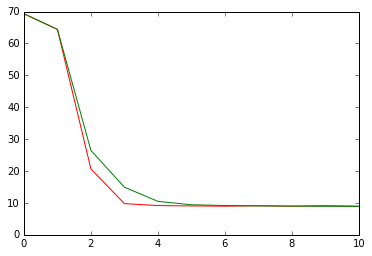

[69.314718055994533, 64.425163584693323, 20.658283483634523, 9.7798697829916108, 9.1648816012910128, 9.0551518442706218, 8.9773483729799715, 9.109038500339933, 8.990469307016328, 9.1366643114323782, 8.9861713555849683]
[69.314718055994533, 64.425163584693323, 26.472338447984782, 14.94085648924302, 10.494792752125154, 9.4193180688446407, 9.1820685522732113, 9.0618336006170424, 8.9885450736635963, 8.9414432085716093, 8.9099178013828091]


In [121]:
lr1 = LogisticRegression(X, y, alpha=0.4, max_epochs=10)
lr1.gradient_decent()

lr2 = LogisticRegression(X, y, alpha=0.4, max_epochs=10, decay_factor=2.0, use_adaptive=True)
lr2.gradient_decent()

plt.plot(lr1.likelihood_history, 'r')
plt.plot(lr2.likelihood_history, 'g')
plt.show()

print lr1.likelihood_history
print lr2.likelihood_history

In [56]:
alphas = [0.01, 0.05, 0.1, 10.5]
err = []
for ax in alphas:
    lr = LogisticRegression(X, y, alpha=ax, max_epochs=200)
    lr.gradient_decent()
    err.append(lr.likelihood_history)
print len(err)

4


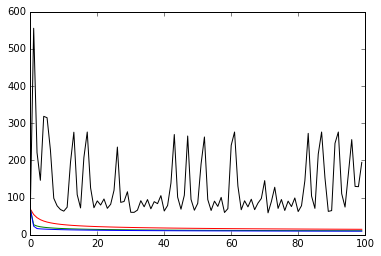

In [58]:
plt.figure(0)
n = 100
plt.plot(err[0][:n], 'r')
plt.plot(err[1][:n], 'g')
plt.plot(err[2][:n], 'b')
plt.plot(err[3][:n], 'black')
plt.show()

In [59]:
def adaptive_alpha(alpha, epoch, total_epochs):
    # Update value of alpha to decrease as training progresses
    return 0

In [93]:
def f3(a, t, n, c):
    return a*np.exp(-1.0*t/float(n*c))

In [101]:
N = 100
t = range(N)
a = 0.1

z3 = []

for ix in range(N):
    z3.append(f3(a, ix, N, 10.0))